# Ensemble Methods
---

_Author: Carleton L. Smith_

<a id = "top"></a>
## Questions
- [Question 1](#q1)
- [Question 2](#q2)
- [Question 3](#q3)
- [Question 4](#q4)
- [Question 5](#q5)
- [Question 6](#q6)
- [Question 7](#q7)
- [Question 8](#q8)
- [Question 9](#q9)
- [Question 10](#q10)

## Assignment Overview

This assignment will:

- Discuss ensemble learning
- Introduce two powerful ensemble methodologies: Bagging and Boosting
- Discuss the mechanics of ensemble algorithms: Random Forest, AdaBoost, and Gradient Boosted Trees (GBT)
- Test your ability to create a Random Forest, AdaBoost, and GBT model in `scikit-learn`

**EXPECTED TIME: 2 HRS**

## Assignment Contents

 - [Introduction](#intro)
     - [Use Case and Dataset](#data)
     - [Quick Exploration](#explore)
 - [Ensemble Learning](#ensembles)
 - [Bagging: _Boostrap Aggregation_](#bagging)
     - [Why Bagging Works](#bagging-works)
     - [Bootstrap Sampling](#bootstrap)
     - [Classification Metrics Review](#classification-metrics)
     - [Random Forest](#random-forest)
     - [ExtraTreesClassifier](#extra-trees)
     - [Out-of-Bag Evaluation](#oob)
 - [Boosting](#boosting)
     - [AdaBoost](#adaboost)
     - [Gradient Boosted Trees (GBT)](#gbt)
 - [Feature Importance](#feature-importance)
 - [References](#references)

[Back to top](#top)

<a id = "intro"></a>
## Introduction

Ensemble methods are popular machine learning procedures because of their performance and interpretability. This assignment will test your understanding of ensembles and your ability to create, fine tune, and interpret their output.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# constants
FILEPATH = './assets/hmeq-preprocessed.csv'
RANDOM_SEED = 42

In [2]:
# read in the data and display the first 5 rows:
hmeq = pd.read_csv(FILEPATH)
display(hmeq.head())

,bad_loan,loan_request,amt_due_on_mort,value_of_property,years_at_job,num_derog_reports,num_delinq_lines,oldest_cl_age,num_recent_cl,num_of_cl,debt_to_inc_ratio,reason_for_loan_DebtCon,reason_for_loan_HomeImp,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self
0,1.0,-1.563111,-1.092273,-1.119977,0.204896,-0.287802,-0.390777,-1.010801,-0.105982,-1.245799,0.100426,0,1,0,0,1,0,0,0
1,1.0,-1.545527,-0.083958,-0.611919,-0.263303,-0.287802,1.444855,-0.689082,-0.693180,-0.749574,0.100426,0,1,0,0,1,0,0,0
2,1.0,-1.527943,-1.374281,-1.506102,-0.664616,-0.287802,-0.390777,-0.365411,-0.105982,-1.146554,0.100426,0,1,0,0,1,0,0,0
3,0.0,-1.510359,0.549123,0.142169,-0.798387,-0.287802,-0.390777,-1.022905,-0.693180,-0.749574,0.100426,0,1,0,1,0,0,0,0
4,1.0,-1.510359,-0.985310,-1.097579,0.004239,-0.287802,-0.390777,-0.927646,-0.105982,-1.345045,0.362816,0,1,0,0,1,0,0,0


<a id = "data"></a>
### Use Case and Dataset

The data for this assignment is a preprocessed version of the [HMEQ Dataset](https://www.kaggle.com/ajay1735/hmeq-data) [<sup>4</sup>](#hmeq) from Kaggle.

**FEATURES:**

_Note: All numeric columns are standardized._

- `loan_request`:  The requested loan amount (numeric)
- `amt_due_on_mort`: The amount due on the individual's existing mortgage (numeric)
- `value_of_property`: The value of the current property (numeric)
- `years_at_job`: Number of years at current job (numeric)
- `num_derog_reports`: Number of major derogatory reports (numeric)
- `num_delinq_lines`: Number of delinquent credit lines (numeric)
- `oldest_cl_age`: Age of oldest trade line in standardized months (numeric)
- `num_recent_cl`: Number of recent credit lines (numeric)
- `num_of_cl`: Number of credit lines (numeric)
- `debt_to_inc_ratio`: The individual's debt to income ratio (numeric)
- `reason_for_loan`: The reason for requesting the loan (categorical)
    - `DebtCon`: Debt consolidation
    - `HomeImp`: Home Improvement
- `occupation`: The individual's job title or profession (categorical)
    - `Mgr`: Manager level
    - `Office`: Office worker
    - `Other`: All other professions
    - `ProfExe`: Professional executive
    - `Sales`: Sales professional
    - `Self`: Self employed

**Target:**
- `bad_loan`: Indicates if the individual defaulted on the loan (binary)
    - `1.0`: Default
    - `0.0`: Loan repaid

Using the features above, you will build a number of ensemble models throughout the assignment.

[Back to top](#top)

<a id = "explore"></a>
### Quick Exploration

Plot the distribution of the target variable: `bad_loan`

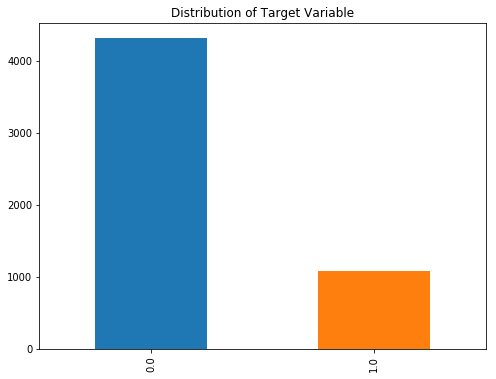

In [3]:
(hmeq['bad_loan']
    .value_counts()
    .plot(
        kind='bar',
        figsize=(8, 6),
        title='Distribution of Target Variable',
    )
);
plt.show()

The target variable, `bad_loan`, is **unbalanced** - meaning the variable contains about 4x more "good" loan instances than "bad" loan instances. This can present a problem since the **positive class** we want to predict is the "bad" loan class (`1.0`).

Because of this unbalanced data, we will make sure that both our training set and testing set **maintain this ratio** of good:bad loans. This is acheived by using the `stratify` argument in the `train_test_split()` function, which was imported from the `sklearn.model_selection` module.

In [4]:
# separate target variable from features
X = hmeq.drop('bad_loan', axis=1)
y = hmeq['bad_loan'].copy()

# partition data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=RANDOM_SEED
                                                    )

[Back to top](#top)
<a id = "q1"></a>

---
#### Question 1

> Given that our target variable (`bad_loan`) is unbalanced, what is the baseline classification accuracy for `X_train`?
> - HINT: The [DummyClassifier](#https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) may be helpful for this exercise.
> - Use the `most_frequent` strategy of calculating the baseline accuracy
> - Assign the baseline accuracy as a decimal (between [0.0-1.0]) to the identifier `ans1`. Round to 3 decimal places.

In [5]:
from sklearn.dummy import DummyClassifier

In [6]:
### GRADED
### 
### 
### Assign `ans1` 
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
ans1 = np.round(dummy_clf.score(X_train, y_train),3)


### For verifying answer:
print(" Baseline Accuracy of X_train:\n","="*29)
print(ans1)

 Baseline Accuracy of X_train:
0.799


In [8]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


[Back to top](#top)

<a id = "ensembles"></a>
## Ensemble Learning

> _"The idea of ensemble learning is to build a prediction model by combining the strengths of a collection of simpler base models._"
>
>
> _The Elements of Statistical Learning_, Chapter 16 [<sup>1</sup>](#ESL)



Simply put, an ensemble method (model) is a collection of individual base models that work together to make a single prediction. For a single instance in a dataset, the ensemble algorithm will aggregate the predictions made by each individual base model and produce a single output prediction. This aggregation process varies across different ensemble architectures.

The priciple idea behind using ensemble learning is that this committee of base models working together will outperform a single complex model. There are generally two families of ensemble methods:

- **Averaging Methods**: Build several models independently and average their predictions.
    - Examples: Bagging, Random Forest
- **Boosting Methods**: Sequentially build a series of weak models, where each sequential model attempts to reduce the overall bias of the ensemble.
    - Examples: AdaBoost, Gradient Boosted Trees

There are many advantages to using ensemble methods.
- **Interpretability**: Ensemble methods can be interpreted, although complex ensembles can sometimes make this difficult.
- **High Performance**: Ensemble methods frequently win machine learning competitions
- **Versatility**: Ensembles can be applied to regression or classification tasks

### Ensemble Module: [`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

The popular Python machine learning package, `scikit-learn`, maintains an excellent module dedicated to ensemble methods. This assignment will ask you to use 2-3 ensemble models from this module. You are encouraged to explore the others at your leisure.

[Back to top](#top)

<a id = "bagging"></a>
## Bagging: _Bootstrap Aggregation_
> 
> "_Bootstrap aggregation,_ or _bagging_, is a general-purpose procedure for reducing the variance of a statistical learning method"
>
> _An Introduction to Statistical Learning: with Applications in R_ [<sup>4</sup>](#ISL)

Bagging (short for *Bootstrap Aggregation*) is an averaging ensembling method that involves independently creating a committee of models, each fit on a different sample of training data. The different batches of training data for each base model is _boostrap sample_. Bootstrapping is discussed in the [Bootstrap Sampling](#bootstrap) section.

<a id = "bagging-works"></a>
### Why Bagging Works

Decision Trees are a popular choice for the base estimator of a Bagging ensemble. As you may recall from learning about Decision Trees, it is very easy to overfit a decision tree to the training data. Furthermore, Decision Trees are known to be _unstable_, meaning a small change in the training data can result in a drastically different Decision Tree.

A tree based Bagging ensemble takes advantage of these shortcomings by fitting each tree on a different bootstrap sample of the training data. Due to the unstable nature of Decision Trees, overfitting each tree to its particular bootstrapped sample will result in an ensemble with a diverse set of trees. While each individual tree is overfit to the data it was trained with, the variance of the overall ensemble is reduced due to this diverse set of trees.

Since boostrapping is fundamental to Bagging, you will learn about that process next.

<a id = "bootstrap"></a>
### Bootstrap Sampling

In short, a bootstrap is a randomly drawn sample *with replacement* in which the sample is of the same cardinality as the original dataset. The next question requires to build a function that will produce a single bootstrap DataFrame.

[Back to top](#top)
<a id = "q2"></a>

---
#### Question 2

> Create a function `create_bootstrap_sample` that accepts take a Pandas `DataFrame` as a parameter and returns a bootstrap sample (also as a Pandas `DataFrame`).
> - Name this function `create_bootstrap_sample` 
> - Use your function to create a single bootstrap sample using `X_train` as input
> - Assign the bootstrap sample as a `pandas` `DataFrame` to the variable `ans2`.

In [9]:
### GRADED
### 
### Create a function that will take df (a Pandas DataFrame) as an input
### parameter and return a bootstrap sample. Assign the output sample to ans2.

def create_bootstrap_sample(df):
    sample_frame = np.random.choice(df.index, size=df.shape[0], replace=True)
    return df.loc[sample_frame, :]

ans2 = create_bootstrap_sample(X_train)

### For verifying answer:
print('-'*60)
print('Number of rows should be the same:')
print('Number of rows in X_train:  ', X_train.shape[0])
print('Number of rows in bootstrap:', create_bootstrap_sample(X_train).shape[0])
print('-'*60)
print('Row labels of bootstrap should have repeated values:')
print('Contains repeat row labels:', bool(~create_bootstrap_sample(X_train).index.is_unique))

------------------------------------------------------------
Number of rows should be the same:
Number of rows in X_train:   3781
Number of rows in bootstrap: 3781
------------------------------------------------------------
Row labels of bootstrap should have repeated values:
Contains repeat row labels: True


In [10]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Now that you understand the bootstrapping process, your next task will be to build a generic Bagging ensemble. You will use the [`BaggingClassifier`](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) class from `scikit-learn` for the next question.

[Back to top](#top)
<a id = "q3"></a>

---
#### Question 3

> Use the [`BaggingClassifier`](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) class from Scikit-Learn, instantiate and fit a model with all the training data.
> - Instantiate the classifier as `ans3a` using the default constructor parameters other than `random_state=42`, i.e., `BaggingClassifier(random_state=42)`.
> - Fit the [`BaggingClassifier`](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) instance `ans3a` using `X_train` and `y_train`.
> - Make a prediction on `X_test` using the `predict` method. Assign the predicted output to the identifier `ans3b`.
> - Score the accuracy on `X_test` & `y_test`; assign the score to the identifier `ans3c`.
>
> **Make sure to set the `random_state` parameter using `BaggingClassifier(random_state=42)` to ensure reproducibility!**

In [11]:
### GRADED
### 
### Instantiate and fit a BaggingClassifier model from sklearn 
### using default constructor arguments.

### Instantiate and fit an instance of `BaggingClassifier` with `X_train` and `y_train`.
### Use all default Constructor parameters, except for `random_state=42`. 
###     Ex: `BaggingClassifier(random_state=42)`
### Assign the fit model to the identifier `ans3a`.
### Make predictions on `X_test` using the `.predict()` method. Assign predictions to identifier `ans3b`.
### Score the accuracy on `X_test` and assign the score to the identifier `ans3c`.
### 
### Make sure to set `random_state` parameter to `BaggingClassifier(random_state=42)` for reproducibility!
### 
from sklearn.ensemble import BaggingClassifier

ans3a = BaggingClassifier(random_state=42)
ans3a.fit(X_train,y_train)
ans3b = ans3a.predict(X_test)
ans3c = ans3a.score(X_test,y_test)


### For verifying answer:
print((' Model (should be sklearn):\n' + ('='*40) + '\n {}\n').format(ans3a))
print((' First 5 predictions:\n' + ('='*40) + '\n {}\n').format(ans3b))
print((' Accuracy:\n' + ('='*40) + '\n {}').format(ans3c))

 Model (should be sklearn):
 BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=42,
         verbose=0, warm_start=False)

 First 5 predictions:
 [0. 0. 1. ... 1. 0. 0.]

 Accuracy:
 0.8963602714373843


In [12]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Save this model for future use.

In [13]:
bagging_model = ans3a       # bagging model
bagging_test_preds = ans3b  # bagging test preds

[Back to top](#top)

<a id = "classification-metrics"></a>
### Classification Metrics Review
An important consideration when evaluating classfier models is how well the model is predicting the "positive" class. In this case, the `1.0` value in the `bad_loan` column will be designated as the positive class.

*Note*: Don't confuse the word "positive" in this case to mean "optimistic". The meaning of "positive" in this context simply means the focus is on identifying default loans (avoiding losses) rather than profitable loans.  The same would be true for a "positive" test result for an illness or a "positive" pregnancy test.

Accuracy does not tell the whole story when evaluating a classifier model with **unbalanced** data. It's likely that the model is better at predicting the the majority class (`0.0`) because there are more samples for that class. We need to look at a few more evaluation metrics to understand how well the model predicts the "positive" class:
<br>
<br>
$$
\begin{align}
\text{accuracy} = \frac{\mathtt{tp} + \mathtt{tn}}{\mathtt{tn} + \mathtt{tp} + \mathtt{fn} + \mathtt{fp}}
\end{align}
$$
<br>
<br>
$$
\begin{align}
\text{recall} = \frac{\mathtt{tp}}{\mathtt{tp} + \mathtt{fn}}
\end{align}
$$
<br>
<br>
$$
\begin{align}
\text{precision} = \frac{\mathtt{tp}}{\mathtt{tp} + \mathtt{fp}}
\end{align}
$$
<br>
<br>

where $\mathtt{tn}$, $\mathtt{tp}$, $\mathtt{fn}$, and $\mathtt{fp}$ are the number of true negatives, true positives, false negatives, and false positives respectively.
<br>
<br>
<br>
<style>
table {align:left;display:block}
</style>


| $$\textbf{Metric}$$ | $$\textbf{Meaning for this Model}$$ |
| :------| :----- |
| $$\mathtt{tp}$$ | $$\text{Number of actual bad loans predicted to be bad loans - the bank avoids losses.}$$ |
| $$\mathtt{tn}$$ | $$\text{Number of actual good loans predicted to be good loans - the bank earns profit.}$$ |
| $$\mathtt{fp}$$ | $$\text{Number of actual bad loans predicted to be good loans (false alarms!) - bank loses  money.)}$$ |
| $$\mathtt{fn}$$ | $$\text{Number of actual good loans predicted to be bad loans - the bank misses opportunity to earn money.}$$ |


<br>
Depending on the use case, you may decide to optimize either $\text{recall}$ or $\text{precision}$. For example, consider a model that predicts if a tumor is malignant (positive class) or benign (negative class) from an ultrasound image. In this case, a $\mathtt{fn}$ is much more costly than a $\mathtt{fp}$, so $\text{recall}$ is more important than $\text{precision}$. The opposite situation could be true for a model that predicts when to replace expensive machinery parts. Machine learning metrics and business/health metrics are not always the same thing. Always consider the true cost you should optimize when model building.

The `scikit-learn.metrics` module conveniently provides functions that will calculate these metrics:

- [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), 
- [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html).

The below cell block demonstrates the `classification_report()` function to evaluate the entire Bagging ensemble.

In [14]:
from sklearn.metrics import (
    classification_report,
    recall_score,
    precision_score,
    accuracy_score
)
print('Classification Report:\n')
print(classification_report(y_test, bagging_test_preds))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      1295
         1.0       0.80      0.64      0.71       326

   micro avg       0.90      0.90      0.90      1621
   macro avg       0.86      0.80      0.83      1621
weighted avg       0.89      0.90      0.89      1621



`scikit-learn` provides users the ability to investigate the individual base models within an ensemble with the `.estimator_` attribute. Let's investigate the recall testing performance using each of the individual base models, which are `DecisionTreeClassifiers` by default.

In [15]:
def print_recall_scores(ensemble, feats, true_labels):
    '''
    Prints the recall scores for base estimators in a sklearn ensemble model.
    '''
    scores = []
    for model_idx, model in enumerate(ensemble.estimators_):
        if model_idx == 0:
            print('='*40)
        preds = model.predict(feats)
        scores.append(recall_score(true_labels, preds))
        model_recall = np.round(recall_score(true_labels, preds), 5)
        print(f'Recall for Base Model {model_idx+1}:\t', model_recall)
        if model_idx < (len(ensemble.estimators_) - 1):
            print('-'*40)
        else:
            print('='*40)
    ensemble_preds = ensemble.predict(feats)
    print("Mean Recall Score:\t\t", np.round(np.array(scores).mean(), 5))
    print("Std Deviation:\t\t\t", np.round(np.array(scores).std(), 5))
    print("Range:\t\t\t\t", np.round(np.array(scores).ptp(), 5))
    print(f'Overall Recall for model:\t {np.round(recall_score(y_test, ensemble_preds), 5)}')

In [16]:
print_recall_scores(bagging_model, X_test, y_test)

Recall for Base Model 1:	 0.61963
----------------------------------------
Recall for Base Model 2:	 0.62577
----------------------------------------
Recall for Base Model 3:	 0.6227
----------------------------------------
Recall for Base Model 4:	 0.61043
----------------------------------------
Recall for Base Model 5:	 0.59816
----------------------------------------
Recall for Base Model 6:	 0.64417
----------------------------------------
Recall for Base Model 7:	 0.60429
----------------------------------------
Recall for Base Model 8:	 0.61656
----------------------------------------
Recall for Base Model 9:	 0.66258
----------------------------------------
Recall for Base Model 10:	 0.61963
Mean Recall Score:		 0.62239
Std Deviation:			 0.01791
Range:				 0.06442
Overall Recall for model:	 0.64417


Notice that the recall on each individual tree is very similar.

The generic Bagging ensemble method will now be compared to a Random Forest model, which is a variant of the standard Bagging method.

[Back to top](#top)

<a id = "random-forest"></a>
### Random Forest

> "Random Forests is a substantial modification of bagging that builds a large collection of _de-correlated_ trees, and averages them."
> 
> _The Elements of Statistical Learning_, Chapter 15 [<sup>1</sup>](#ESL)

When constructing a tree within a bagging ensemble, all input features are considered to determine the best split. If the data contains one or two dominant features, those dominant features are always selected first in every tree within the ensemble, resulting in a high correlation among the trees.

The Random Forest algorithm further reduces the model error due to variance by de-correlating each tree within the ensemble. This is acheived by considering only a sample of features from the available feature set at each split in the decision tree. This procedure results in a higher diversity of trees within the ensemble, which can reduce the overall variance.

[Back to top](#top)
<a id = "q4"></a>

---
#### Question 4

> Your task now is to build a Random Forest model using the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class from `scikit-learn`.
>
> - Instantiate a `RandomForestClassifier` using the constructor arguments: `n_estimators=10`, `max_features=7` and `random_state=42`, i.e., `RandomForestClassifier(n_estimators=10, max_features=7, random_state=42)`. Assign the resulting object to the identifier `ans4a`.
> - Fit the object `ans4a` using the training data `X_train` and `y_train`.
> - Make predictions on `X_test`. Assign the resulting predictions to `ans4b` as a 1D numpy array.
> - Calculate the recall using the testing data and assign the value to `ans4c`. Round to 4 decimal places.
> - Calculate the precision using the testing data and assign the value to `ans4d`. Round to 4 decimal places.

In [18]:
### GRADED
### 
### Instantiate and fit a `RandomForestClassifier` model to `X_train`.
### Use the following constructor arguments: `max_features=7` and `random_state=42`
### Ex: RandomForestClassifier(max_features=7, random_state=42)
### Assign the fitted model to the identifier `ans4a`
### Make predictions on `X_test`. Assign the predictions to `ans4b` as a 1D numpy array.
### Calculate the recall on testing and assign the value to `ans4c`. Round to 4 decimal places.
### Calculate the precision on testing and assign the value to `ans4d`. Round to 4 decimal places.
### 
from sklearn.ensemble import RandomForestClassifier
ans4a = RandomForestClassifier(n_estimators=10, max_features=7, random_state=42)
ans4a.fit(X_train, y_train)
ans4b = ans4a.predict(X_test)
ans4c = np.round(recall_score(y_test,ans4b),4)
ans4d = np.round(precision_score(y_test,ans4b),4)

### For verifying answer:
print('Type for answer for ans4a:', type(ans4a))
print('Type for answer for ans4b:', type(ans4b))
print('Type for answer for ans4c:', type(ans4c))
print('Type for answer for ans4d:', type(ans4d))

Type for answer for ans4a: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Type for answer for ans4b: <class 'numpy.ndarray'>
Type for answer for ans4c: <class 'numpy.float64'>
Type for answer for ans4d: <class 'numpy.float64'>


In [19]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Save the Random Forest model for later.

In [20]:
rfc = ans4a

[Back to top](#top)

The implementation of Random Forest should de-correlate the trees from each other, resulting in a higher variance in performance on `X_test` when we look at each individual tree in the ensemble.

In [21]:
print_recall_scores(rfc, X_test, y_test)

Recall for Base Model 1:	 0.63804
----------------------------------------
Recall for Base Model 2:	 0.65031
----------------------------------------
Recall for Base Model 3:	 0.64724
----------------------------------------
Recall for Base Model 4:	 0.63804
----------------------------------------
Recall for Base Model 5:	 0.60123
----------------------------------------
Recall for Base Model 6:	 0.6319
----------------------------------------
Recall for Base Model 7:	 0.64724
----------------------------------------
Recall for Base Model 8:	 0.59509
----------------------------------------
Recall for Base Model 9:	 0.68098
----------------------------------------
Recall for Base Model 10:	 0.61963
Mean Recall Score:		 0.63497
Std Deviation:			 0.02376
Range:				 0.08589
Overall Recall for model:	 0.63804


The `BaggingClassifier` and `RandomForestClassifier` have similar overall recall scores, but the variance of recall scores among the individual Decision Trees is higher in the Random Forest due to the additional sampling of the feature space as the trees are constructed. The trees within the Random Forest model are more diverse.

<a id = "extra-trees"></a>
### ExtraTreesClassifier

It's possible to make the tree ensemble even more random by using _extremely randomized trees_. In extremely randomized trees, each base learner is constructed using a bootstrap sample of the training data (just like in bagging). At each split during the construction of a tree, a subset of features are selected as candidates to make the split (just like Random Forest), but instead of finding the optimal threshold to split each candidate feature, a random threshold is chosen. The feature with the best randomly selected threshoold is then chosen as the splitting rule at that node.

[Back to top](#top)
<a id = "q5"></a>

---
#### Question 5

> Your task is to build an extremely randomized tree model using the [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)  class from `scikit-learn`.
>
> - Instantiate and fit an `ExtraTreesClassifier` model to the training data (using the constructor arguments `n_estimators=10`, `max_features=7`, and `random_state=42`).
> - Assign the model to the identifier `ans5a`.
> - Make predictions on `X_test`. Assign the predictions to `ans5b` as a 1D numpy array.
> - Calculate the recall on testing and assign the value to `ans5c`. Round to 4 decimal places.
> - Calculate the precision on testing and assign the value to `ans5d`. Round to 4 decimal places.

In [22]:
### GRADED
### 
### Instantiate and fit a `ExtraTreesClassifier` model to `X_train`.
### Use the following constructor arguments: `max_features=7` and `random_state=42`
### Ex: ExtraTreesClassifier(max_features=7, random_state=42)
### Assign the fitted model to the identifier `ans5a`
### Make predictions on `X_test`. Assign the predictions to `ans5b` as a 1D numpy array.
### Calculate the recall on testing and assign the value to `ans5c`. Round to 4 decimal places.
### Calculate the precision on testing and assign the value to `ans5d`. Round to 4 decimal places.
### 
from sklearn.ensemble import ExtraTreesClassifier
ans5a = ExtraTreesClassifier(max_features=7, random_state=42)
ans5a.fit(X_train,y_train)
ans5b = ans5a.predict(X_test)
ans5c = np.round(recall_score(y_test,ans5b),4)
ans5d = np.round(precision_score(y_test,ans5b),4)


### For verifying answer:
print('Type for answer for ans5a:', type(ans5a))
print('Type for answer for ans5b:', type(ans5b))
print('Recall :\t {}'.format(ans5c))
print('Precision :\t {}:'.format(ans5d))

Type for answer for ans5a: <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
Type for answer for ans5b: <class 'numpy.ndarray'>
Recall :	 0.681
Precision :	 0.9569:


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Save the Extra Trees model for later.

In [ ]:
extra_tree_model = ans5a

[Back to top](#top)
<a id = "q6"></a>

<a id = "oob"></a>
### Out-of-Bag Evaluation

Through the process of bootstrap sampling, some instances can be sampled multiple times, while other instances are left out of the sample altogether. The samples that are left out of the bootstrap sample are known as "out-of_bag" (oob) samples. Since these observations are not used during the training of a particular base learner, the oob instances can be used as testing samples. This eliminates the need to withhold data from training for the purpose of evaluation.

Ensemble models in `scikit-learn` contain a parameter in the model constructors called `oob_score`. Setting `oob_score=True` will enable this implementation. After fitting the model, the evaluation results can be found in the attribute `.oob_score_`.

---
#### Question 6

> Your task is to create another `RandomForestClassifier` model using `X_train`, but 
this time setting the `oob_score` parameter to `True`. You will then compare the 
oob accuracy score to the accuracy of the model on `X_test`.
> 
> - Instantiate and fit a `RandomForestClassifier` model to `X_train`.
Use the following constructor arguments: `n_estimators=100`, `max_features=7`, `oob_score=True`, and `random_state=42`
> - Assign the fitted model to the identifier `ans6a`.
> - Assign the `oob_score_` (accuracy) to the identifier `ans6b`. Round to 4 decimal places.
> - Calculate the accuracy on `X_test` and assign the value to `ans6c`. Round to 4 decimal places.
> - Calculate the absolute difference between the oob accuracy (`ans6b`) and testing accuracy (`ans6c`) & assign the value computed to the identifier `ans6d`. Round to 4 decimal places.

In [23]:
### GRADED
### 
### Instantiate and fit a `RandomForestClassifier` model to `X_train`.
### Use the following constructor arguments: 
###     - `n_estimators=100`
###     - `max_features=7`,
###     - `oob_score=True`
###     - `random_state=42`
### Assign the fitted model to the identifier `ans6a`.
### Assign the oob_score_ (accuracy) to the identifier `ans6b`. Round to 4 decimal places.
### Calculate the accuracy on testing and assign the value to `ans6c`. Round to 4 decimal places.
### Calculate the difference between the oob_score_ (`ans6b`) and testing accuracy (`ans6c`).
### Assign the absolute difference between `ans6b` and `ans6c` to the identifier `ans6d`. Round to 4 decimal places.
from sklearn.ensemble import RandomForestClassifier

ans6a = RandomForestClassifier(n_estimators=100,max_features=7,oob_score=True,random_state=42)
ans6a.fit(X_train,y_train)
ans6b = np.round(ans6a.oob_score_,4)
prediction = ans6a.predict(X_test)
ans6c = np.round(accuracy_score(y_test,prediction),4)
ans6d = abs(ans6b-ans6c)


### For verifying answer:
print('Type for answer for ans6a:\t', ans6a)
print('OOB Score:\t\t\t', ans6b)
print('Testing Accuracy:\t\t', ans6c)
print('Acc. Difference:\t\t', ans6d)

Type for answer for ans6a:	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)
OOB Score:			 0.9127
Testing Accuracy:		 0.9155
Acc. Difference:		 0.0028000000000000247


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


[Back to top](#top)
<a id = "q7"></a>

<a id = "boosting"></a>
## Boosting
> "Boosting is one of the most powerful learning ideas introduced in the last twenty years."
>
>
> _The Elements of Statistical Learning_, Chapter 10 [<sup>1</sup>](#ESL)


Boosting is fundamentally different than bagging. Bagging ensembles attempt to reduce overall _variance_ by fitting models independently on bootstapped samples. Boosting methods attempt to reduce _bias_ by sequentially improving the overall predictions. That is, base learner $m$ attempts to correct the predictions produced by the base learner $m-1$, for $m=1$ to $M$.

---
#### Question 7

> **True or False**
> 
> Determine if the following statement is True or False. Provide your answer as a boolean literal (`True` or `False`) to the identifier `ans7`.
> 
>
> _Each base model in a Boosting Ensemble should be overfit to the data, just as in Bagging._

In [26]:
### GRADED
### True or False: Each base model in a Boosting Ensemble should be 
### overfit to the data, just as in Bagging.
### 
### Provide your answer as a boolean literal (True or False) to
## the identifier ans7.

ans7 = False


### For verifying answer:
if type(ans7)!= bool:
    print('Please provide your response as a boolean literal (True or False)')
    print('Your response type: {}.'.format(type(ans7)))
    print('Correct response type: {}.'.format(bool))

In [27]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


<a id = "adaboost"></a>
### AdaBoost

One of the prototypical boosting algorithms was Adaptive Boosting, or AdaBoost. The AdaBoost algorithm begins by assigning equal weights to every observation in the training data. The base learner in the ensemble is fit on the training data and produces predictions. Based on these predictions, the weights are adjusted to increase the for misclassified observations and reduced for correctly classified observations. Each model repeats this procedure of making predictions and updating the weights accordingly.

The principle idea behind AdaBoost is that difficult to predict cases get assigned a heavier and heavier weight so that base learners futher down the ensemble become better at predicting them. We will now practice building and evaluating an AdaBoost model in `scikit-learn`.

[Back to top](#top)
<a id = "q8"></a>

---
#### Question 8

> Your task is to build two AdaBoost models with TRAINING data using the [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) class from `scikit-learn` and report the best `recall_score()` on TESTING.
>
> "MODEL 1" Hyperparameters:
> - Use `DecisionTreeClassifier(max_depth=2)` as base estimator
> - Set `n_estimators=500`
> - Set `random_state=42`
> - Set `learning_rate = 0.05`
>
> "MODEL 2" Hyperparameters::
> - Use `DecisionTreeClassifier(max_depth=2)` as base estimator
> - Set `n_estimators=20`
> - Set `random_state=42`
> - Set `learning_rate = 0.5`
>
> - Calculate the "MODEL 1" recall on testing and assign the value to `ans8a`. Round to 4 decimal places.
> - Calculate the "MODEL 2" recall on testing and assign the value to `ans8b`. Round to 4 decimal places.
> - Assign `ans8c` to the string "MODEL 1" or "MODEL 2" depending on which model had a better recall on TESTING.

In [29]:
### GRADED
### 
### 
### Assign `ans8` 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base = DecisionTreeClassifier(max_depth=2)

ada1 = AdaBoostClassifier(base,n_estimators=500,random_state=42,learning_rate = 0.05)
ada1.fit(X_train, y_train)
prediction1 = ada1.predict(X_test)
ans8a = np.round(recall_score(y_test,prediction1),4)

ada2 = AdaBoostClassifier(base,n_estimators=20,random_state=42,learning_rate = 0.5)
ada2.fit(X_train, y_train)
prediction2 = ada2.predict(X_test)
ans8b = np.round(recall_score(y_test,prediction2),4)

ans8c = 'MODEL 1'


### For verifying answer:
print('Winning Model:\t {}'.format(ans8c))
print('MODEL 1 Recall:\t {}'.format(ans8a))
print('MODEL 2 Recall:\t {}:'.format(ans8b))

Winning Model:	 MODEL 1
MODEL 1 Recall:	 0.6933
MODEL 2 Recall:	 0.6411:


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


[Back to top](#top)

<a id = "gbt"></a>
### Gradient Boosted Trees (GBT)

An extremely popular boosting algorithm is Gradient Booosted Trees. Instead of re-weighting observations based on the prediction performance, Gradient Boosted Trees attempt to correct the residuals errors of the preceding models. The initial base estimator is fit on the training data. From then on, subsequent model is fit on the previous model's residuals.

[Back to top](#top)
<a id = "q9"></a>

---
#### Question 9

> Your task is to create now use `GradientBoostingClassifier` model using `X_train` & `y_train`.
>
> - Instantiate and fit a `GradientBoostingClassifier` model to the training data (using default constructor arguments except for `random_state=42`).
> - Assign the model to the identifier `ans9a`.
> - Make predictions on `X_test`. Assign the predictions to `ans9b` as a 1D numpy array.
> - Calculate the recall on testing and assign the value to `ans9c`. Round to 4 decimal places.
> - Calculate the precision on testing and assign the value to `ans9d`. Round to 4 decimal places.

In [30]:
### GRADED
### Create a GradientBoostingClassifier as described above (assigning the
###   appropriate objects to ans9a through ans9d).
### YOUR SOLUTIONS HERE:
from sklearn.ensemble import GradientBoostingClassifier
ans9a = GradientBoostingClassifier(random_state=42)
ans9a.fit(X_train,y_train)
ans9b = ans9a.predict(X_test)
ans9c = np.round(recall_score(y_test,ans9b),4)
ans9d = np.round(precision_score(y_test,ans9b),4)


### For verifying answer:
print('Type for answer for ans9a:', type(ans9a))
print('Type for answer for ans9b:', type(ans9b))
print('Recall :\t {}'.format(ans9c))
print('Precision :\t {}:'.format(ans9d))

Type for answer for ans9a: <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
Type for answer for ans9b: <class 'numpy.ndarray'>
Recall :	 0.6595
Precision :	 0.8333:


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Save this model for the next question on feature importance.

In [31]:
gbt_model = ans9a

<a id = "feature-importance"></a>
## Feature Importance

A fantastic characteristic of many ensemble models is that you have the ability to interpret the feature importance. As you learned with Decision Trees, the most important features are selected first during the construction of a tree. Using the gini or information gain generated from using a feature to make a split, a feature importance score can be calculated.

In the case of ensembles, these feature importance scores are aggregated over all of the trees within the ensemble. `scikit-learn` conveniently calculates a `.feature_importance_` score for many of their ensemble implementations.

[Back to top](#top)
<a id = "q10"></a>

---
#### Question 10

> You task find the most important feature from the fitted `GradientBoostingClassifier` model from Question 9.
> - Based on the `feature_importances_` attribute, assign the top feature to the identifier `ans10` as a string literal.

_Note_: You may need to research how to map the feature importance scores stored in `gbt_model.feature_importances_` back to their respective column name.

In [41]:
### GRADED
### Identify the most important feature from gbt_model as found from Question 9.
### Assign your result as a Python string to ans10.
### YOUR SOLUTION HERE:
print(sorted(list(zip(X_train.columns,gbt_model.feature_importances_)), key=lambda x: x[1]))
ans10 = "debt_to_inc_ratio"


### For verifying answer:
print(f'Top Feature:\t{ans10}')

[('reason_for_loan_DebtCon', 0.0), ('reason_for_loan_HomeImp', 0.0), ('occupation_Other', 0.0005528034230555963), ('occupation_Self', 0.0005672201577792003), ('occupation_Mgr', 0.0018724613813850632), ('occupation_Sales', 0.0028872939335593335), ('occupation_Office', 0.005593242294894303), ('occupation_ProfExe', 0.006642313621074149), ('years_at_job', 0.01525166017360266), ('num_recent_cl', 0.023997960826799607), ('amt_due_on_mort', 0.029238057065466595), ('value_of_property', 0.03852189715013419), ('loan_request', 0.03881509481574239), ('num_of_cl', 0.04333319867339297), ('oldest_cl_age', 0.07476710610561932), ('num_derog_reports', 0.0919714006039573), ('num_delinq_lines', 0.13455923859049168), ('debt_to_inc_ratio', 0.4914290511830456)]
Top Feature:	debt_to_inc_ratio


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


[Back to top](#top)

<a id = "references"></a>
## References

Several explanations and examples in this assignment came from the following excellent resources.
<a id = "ESL"></a>
1. Hastie, Trevor, et al. _The Elements of Statistical Learning, Second Edition: Data Mining, Inference, and Prediction_. Springer, 2009.
<a id = "hands-on"></a>
2. Géron Aurélien. _Hands-on Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_. O'Reilly Media, 2017.
<a id = "pml"></a>
3. Raschka, Sebastian. _Python Machine Learning_. Packt, 2015.
4. “An Introduction to Statistical Learning: with Applications in R.” _An Introduction to Statistical Learning: with Applications in R_, by Gareth James et al., Springer, 2017, pp. 316–316.

<a id = "hmeq"></a>
Dataset:
4. HMEQ Dataset: https://www.kaggle.com/ajay1735/hmeq-data

[Back to top](#top)